</br>

<div> 
    <h3 align="right"> 
        <span style="color:#59008A">
            Sertan Avdan & Özkan Kara
        </span>
    </h3> 
</div>

# Variational Autoencoder (VAE)
In this notebook, we implement a Variational Autoencoder (VAE) for generating new images from a given dataset. VAEs are a type of generative model that learn a low-dimensional latent representation of the input data. They consist of an encoder, which maps the input data to a latent space, and a decoder, which reconstructs the input data from the latent space. The key feature of VAEs is the introduction of a variational layer that models the latent space as a probabilistic distribution.

## Process Overview
Import necessary libraries: We import the required libraries, such as PyTorch, NumPy, pandas, seaborn, and matplotlib for implementing the VAE and visualizing the results.

Load and preprocess the dataset: The dataset is loaded using a DataLoader, which provides an easy way to iterate through batches of images. The images are preprocessed by resizing and normalizing them.

Define the VAE architecture: The VAE consists of an encoder and a decoder. The encoder maps the input image to the parameters of a Gaussian distribution in the latent space. The decoder reconstructs the image from a sample drawn from this Gaussian distribution.

Define the loss function: The loss function consists of two parts: the reconstruction loss (Binary Cross-Entropy loss) and the Kullback-Leibler divergence (KLD). The reconstruction loss measures how well the decoder can reconstruct the input images, while the KLD measures the difference between the learned latent distribution and the prior distribution.

## Training loop: We train the VAE using the following steps:

1. Iterate through the dataset for a given number of epochs.
2) Load a batch of images and move them to the appropriate device (CPU or GPU).
3) Perform a forward pass through the encoder to obtain the parameters of the Gaussian distribution in the latent space.
4) Sample a point from the Gaussian distribution and pass it through the decoder to generate a reconstructed image.
5) Compute the loss (reconstruction loss + KLD) and perform backpropagation.
6) Update the model's parameters using an optimizer.
7) Visualize the training loss: We store the training loss for each epoch in a list and plot it using seaborn and matplotlib to analyze the training progress.

Generate new images: After training, we can use the VAE to generate new images by sampling from the latent space and passing the samples through the decoder.

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import torchvision.models as models

import cv2
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import heapq
import itertools

/usr/lib/python3/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /usr/lib/python3/dist-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
dir = 'balanced_data/'
balance_dir = 'balanced_data/'

classes = os.listdir(dir)
num_classes = len(classes)

print(
    f'Number of classes: {num_classes}',
    f'\nClasses: {classes}'
)

Number of classes: 4 
Classes: ['cloudy', 'rain', 'shine', 'sunrise']


In [3]:
print("--------data--------")
# check the number of images in each class
for cls in classes:
    print(f'{cls}: {len(os.listdir(balance_dir + cls))}')

--------data--------
cloudy: 961
rain: 956
shine: 941
sunrise: 934


In [4]:
import os
import imghdr
import shutil

def delete_irrelevant_files(directory, classes):
    for cls in classes:
        class_dir = os.path.join(directory, cls)
        with os.scandir(class_dir) as entries:
            for entry in entries:
                # Delete directories
                if entry.is_dir():
                    print(f'Deleting directory: {entry.path}')
                    shutil.rmtree(entry.path)

                # Check if the file is empty and delete it
                elif os.path.getsize(entry.path) == 0:
                    print(f'Deleting empty file: {entry.path}')
                    os.remove(entry.path)

                # Check if the file is not an image and delete it
                elif not imghdr.what(entry.path):
                    print(f'Deleting non-image file: {entry.path}')
                    os.remove(entry.path)

                # Check if the image size is lower than 128x128 pixel 
                elif Image.open(entry.path).size < (128, 128):
                    print(f'Deleting image with size lower than 128x128: {entry.path}')
                    os.remove(entry.path)

print("--------data--------")
delete_irrelevant_files(balance_dir, classes)

--------data--------


In [5]:
images_ = []
for cls in classes:
    img = cv2.imread(balance_dir + cls + '/' + os.listdir(balance_dir + cls)[-2])
    #img = Image.open(dir + cls + '/' + os.listdir(dir + cls)[0])
    images_.append(img)

images = []
for cls in classes:
    img = cv2.imread(balance_dir + cls + '/' + os.listdir(balance_dir + cls)[0])
    #img = Image.open(dir + cls + '/' + os.listdir(dir + cls)[0])
    images.append(img)

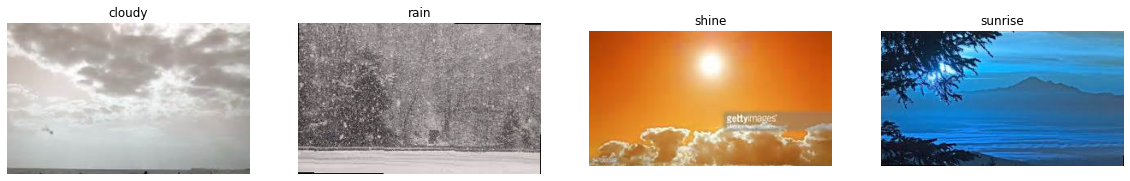

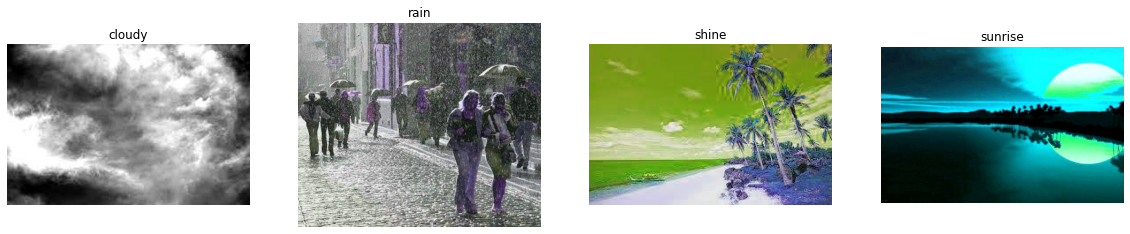

In [6]:
%matplotlib inline

fig, axes = plt.subplots(1, 4, figsize=(20, 20))
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title(classes[i])
    ax.axis('off')


fig, axes = plt.subplots(1, 4, figsize=(20, 20))
for i, ax in enumerate(axes):
    ax.imshow(images_[i])
    ax.set_title(classes[i])
    ax.axis('off')

In [7]:
class WeatherDataset(Dataset):
    def __init__(self, directory, classes, transform=None):
        self.directory = directory
        self.classes = classes
        self.transform = transform
        self.data = []

        for cls in classes:
            class_dir = os.path.join(directory, cls)
            with os.scandir(class_dir) as entries:
                for entry in entries:
                    self.data.append((entry.path, cls))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        label_idx = self.classes.index(label)  # Convert the label to its index
        return image, label_idx


In [8]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# Load the WeatherDataset
dataset = WeatherDataset(directory=balance_dir, classes=['cloudy', 'rain', 'shine', 'sunrise'], transform=transform)                         
print(f'Test dataset size: {len(dataset)}')

Test dataset size: 3792


In [9]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
class Flatten(nn.Module):
  def forward(self, input):
    return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def __init__(self, h_dim):
        super(UnFlatten, self).__init__()
        self.h_dim = h_dim

    def forward(self, input):
        return input.view(input.size(0), self.h_dim, 1, 1)


In [12]:
class ConvVAE(nn.Module):
  def __init__(self, image_channels=3, z_dim=32):
    super(ConvVAE, self).__init__()

    self.h_dim = 256 * 32 * 32
    self.z_dim = z_dim
    self.feature_size = 32

    self.encoder = nn.Sequential(
      nn.Conv2d(image_channels, 32, kernel_size=3, stride=1, padding=1, bias=False),
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.Dropout(0.5),

      nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.Dropout(0.25),

      nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.Dropout(0.125),

      nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.Dropout(0.075),
    )
      
    self.fc1 = nn.Linear(self.h_dim, z_dim)
    self.fc2 = nn.Linear(self.h_dim, z_dim)
    self.fc3 = nn.Linear(z_dim, self.h_dim)
      
    self.decoder = nn.Sequential(
      UnFlatten(self.h_dim),

      nn.ConvTranspose2d(self.h_dim, 128, kernel_size=3, stride=1, padding=1, bias=False),
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.Dropout(0.25),

      nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1, bias=False),
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.Dropout(0.125),

      nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.Dropout(0.075),

      # Start of the upscaling layers to reach the desired output size (64, 64)
      nn.ConvTranspose2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

      nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1),
      nn.AdaptiveAvgPool2d((128, 128)),
      nn.Sigmoid()
    )

  def reparameterize(self, mu, logvar):
    std = logvar.mul(0.5).exp_()
    # return torch.normal(mu, std)
    esp = torch.randn(*mu.size())
    esp = esp.to(device)
    z = mu + std * esp
    return z
    
  def bottleneck(self, h):
    mu, logvar = self.fc1(h), self.fc2(h)
    z = self.reparameterize(mu, logvar)
    return z, mu, logvar

  def encode(self, x):
    h = self.encoder(x)
    z, mu, logvar = self.bottleneck(h)
    return z, mu, logvar

  def decode(self, z):
    z = self.fc3(z)
    z = self.decoder(z)
    return z

  def forward(self, x):
    # Encoding
    for layer in self.encoder:
      x = layer(x)
      # print("Encoder:", x.shape)  # Print the shape after each encoder layer

    x = x.view(x.size(0), -1)
    # print("Flatten:", x.shape)  # Print the shape after Flatten

    mu, logvar = self.fc1(x), self.fc2(x)
    # print("FC1 (mu):", mu.shape, "FC2 (logvar):", logvar.shape)  # Print the shapes after FC1 and FC2
    
    z = self.reparameterize(mu, logvar)
    
    z_decoded = self.fc3(z)
    # print("FC3 (z_decoded):", z_decoded.shape)  # Print the shape after FC3
     
    z_decoded = z_decoded.view(z_decoded.size(0), 256, self.feature_size, self.feature_size)  # Use 256 instead of self.h_dim
    # print("UnFlatten:", z_decoded.shape)  # Print the shape after UnFlatten

    # Decoding
    for layer in self.decoder:
      z_decoded = layer(z_decoded)
      # print("Decoder:", z_decoded.shape)  # Print the shape after each decoder layer

    return z_decoded, mu, logvar

model = ConvVAE()
model.cuda(device)

ConvVAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (9): ReLU(inplace=True)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.125, inplace=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (13): ReLU(inplace=True)
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0

In [13]:
#save the model as txt
with open('model.txt', 'w') as f:
    print(model, file=f)

In [14]:
import torch.optim as optim
import torch.nn.functional as F

print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

Train dataset size: 3033
Test dataset size: 759


In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6, weight_decay=0.0001)

def loss_fn(recon_x, x, mu, logvar):
  BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
  # BCE = F.mse_loss(recon_x, x, size_average=False)

  # see Appendix B from VAE paper:
  # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
  # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
  KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

  return BCE + KLD, BCE, KLD

In [16]:
import math
import time
from IPython.display import clear_output

def plot_images(images, labels, no):
    fig = plt.figure(figsize=(10, 10))
    cols = int(np.sqrt(no))
    rows = int(np.ceil(no / cols))

    for idx in range(min(no, len(images))):
        ax = fig.add_subplot(rows, cols, idx+1, xticks=[], yticks=[])
        imshow(images[idx])
        ax.set_title(classes[labels[idx].item()])  # Convert the label tensor to a Python integer

    plt.show()

def imshow(img):    
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

#classes
classes = ['cloudy', 'rain', 'shine', 'sunrise']

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Epoch: 250 Training Loss: -1013850.201


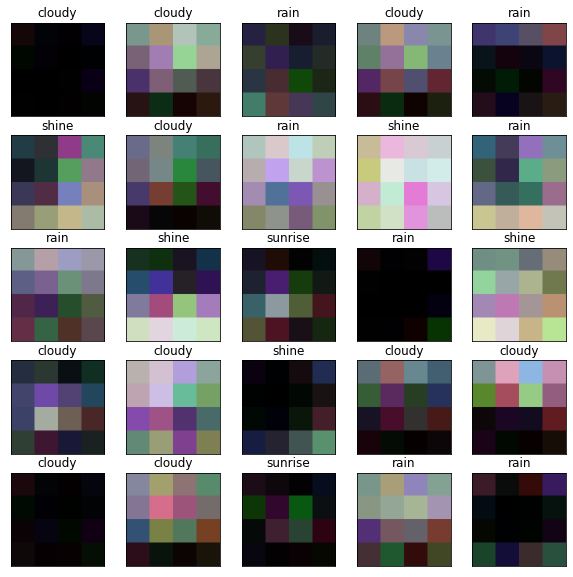

In [18]:
epochs = 250
train_loss_list = []

last_batch_labels = None

for epoch in range(epochs):    
    train_loss = 0.0
    print("------------ Epoch Started ------------")
    for data in train_loader:
        images, labels = data
        images = images.to(device)
        
        last_batch_labels = labels

        # Run the training loop once
        optimizer.zero_grad()
        generated, mu, logvar = model(images)
        loss, bce, kld = loss_fn(generated, images, mu, logvar)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_loss_list.append(train_loss)
    clear_output()
    print(f'Epoch: {epoch+1} Training Loss: {train_loss:.3f}')    
    num_images = generated.size(0)
    plot_images(generated.cpu().data, last_batch_labels.cpu(), num_images)

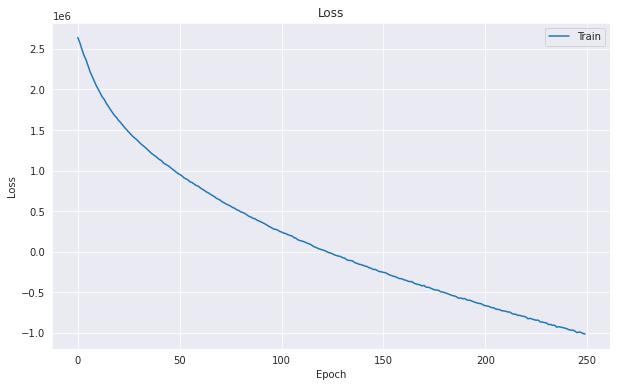

In [19]:
train_loss_list_df = pd.DataFrame({'Epoch': range(len(train_loss_list)), 'Loss': train_loss_list, 'Type': 'Train'})

# Plot the graph
sns.set_style('darkgrid')
plt.figure(figsize=(10, 6))
sns.lineplot(data=train_loss_list_df, x='Epoch', y='Loss', hue='Type')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Save the graph to a file
plt.savefig('loss_graph_Adam.png', dpi=300)

plt.show()

Original images


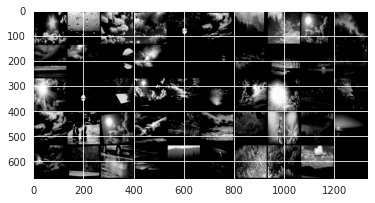

VAE reconstruction:


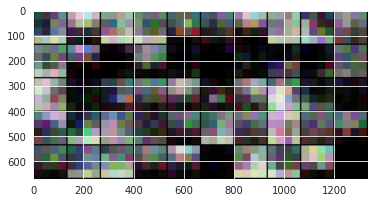

In [20]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):
    with torch.no_grad():    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = next(iter(train_loader))

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10, 5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, model)

In [21]:
# define a function to check pytorch version
def check_pytorch_version():
    if torch.__version__ >= '1.6.0':
        return True
    else:
        return False
    
# define a function to check cuda version
def check_cuda_version():
    if torch.cuda.is_available():
        return True
    else:
        return False
    
# define a function to check cudnn version
def check_cudnn_version():
    if check_cuda_version():
        if torch.backends.cudnn.enabled:
            return True
        else:
            return False
    else:
        return False
    
# define a function to check if the system is ready for training
def check_system():
    if check_pytorch_version():
        print('PyTorch version: {}'.format(torch.__version__))
    else:
        print('PyTorch version: {} (update required)'.format(torch.__version__))
        
    if check_cuda_version():
        print('CUDA version: {}'.format(torch.version.cuda))
    else:
        print('CUDA version: {} (install CUDA to enable GPU training)'.format(torch.version.cuda))
        
    if check_cudnn_version():
        print('cuDNN version: {}'.format(torch.backends.cudnn.version()))
    else:
        print('cuDNN version: {} (install cuDNN to enable GPU training)'.format(torch.backends.cudnn.version()))

check_system()

PyTorch version: 2.0.0+cu118
CUDA version: 11.8
cuDNN version: 8700


In [22]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu118

[notice] A new release of pip available: 22.3 -> 23.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [23]:
!pip install cumm-cu118

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3 -> 23.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [24]:
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3 -> 23.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
